# Phase 4 Project

## Business Objective

To help Acme Online, an online electronics store, analyze customer tweets from their Twitter page about Apple and Google products. The result of this analysis will be used to find out which company's product has more favourable reviews and the reasons behind it - this will help Acme Online adjust their inventory accordingly.

## Methodology

1. Analyze tweets to check which product category is the most popular among customers.
2. Analyze tweets to check what customers like/dislike about each category.
2. We will attempt to build a model using NLP that helps classify tweets based on Apple or Google products. We will use the f1-score for model evaluations since reducing FP's and FN's is more valuable in this case.

# Dataset

Dataset sourced from CrowdFlower via data.world: https://data.world/crowdflower/brands-and-product-emotions

# Analysis

In [1]:
#import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import f1_score,accuracy_score
from sklearn.pipeline import Pipeline
import numpy as np
from nltk import word_tokenize
from gensim.models import Word2Vec
from nltk.tokenize import RegexpTokenizer
from nltk import FreqDist
import warnings
warnings.filterwarnings('ignore')

In [2]:
df= pd.read_csv('tweets.csv',encoding='unicode escape',)
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Pre-processing

***To save ourselves from lot's of keystrokes, let's rename the columns***

In [3]:
#renaming the columns to make it less cumbersome
df.rename(columns={'emotion_in_tweet_is_directed_at':'product_service',
                   'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'},inplace=True)
df.head()

,tweet_text,product_service,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
#getting some info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_text       9092 non-null   object
 1   product_service  3291 non-null   object
 2   emotion          9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


***There are no numeric values in our df which is what we'd expect given that we're analyzing tweets***

In [5]:
#checking for null values
df.isna().sum()

tweet_text            1
product_service    5802
emotion               0
dtype: int64

***From the above,we can see that the `product_service` column has a large number of missing values; more than 50%. Let's leave it for now and remove the one empty row in `tweet_text`***

In [6]:
df = df[df['tweet_text'].notnull()]

In [7]:
#examining the product_service column
df['product_service'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product_service, dtype: int64

In [8]:
#let's group product/services that resemble each other for both brands. This will make for easier analysis

df['product_service'].replace('Other Google product or service','Google',inplace=True)
df['product_service'].replace('Other Apple product or service','Apple',inplace=True)
df['product_service'].replace('Android App','Android',inplace=True)
df['product_service'].fillna('Not Applicable',inplace=True)

#checking
df['product_service'].value_counts()

Not Applicable        5801
iPad                   946
Google                 723
Apple                  696
iPad or iPhone App     470
iPhone                 297
Android                159
Name: product_service, dtype: int64

***Let's apply some of the common pre-processing steps when it comes to working with text data:***

1. ***Remove capitalization***
2. ***Remove puntuations and special characters***
3. ***Tokenizing***

In [9]:
# Removing capiltalization
df['tweet_text'] = df['tweet_text'].str.lower()

#removing punctuations using the default pattern in sklearn and tokenizing
basic_token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(basic_token_pattern)

#applying the tokenizer to the df

df['text_token'] = df['tweet_text'].apply(tokenizer.tokenize)
df.head(10)

,tweet_text,product_service,emotion,text_token
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,iPhone,Negative emotion,"[wesley83, have, 3g, iphone, after, hrs, tweet..."
1,@jessedee know about @fludapp ? awesome ipad/i...,iPad or iPhone App,Positive emotion,"[jessedee, know, about, fludapp, awesome, ipad..."
2,@swonderlin can not wait for #ipad 2 also. the...,iPad,Positive emotion,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,"[sxsw, hope, this, year, festival, isn, as, cr..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."
5,@teachntech00 new ipad apps for #speechtherapy...,Not Applicable,No emotion toward brand or product,"[teachntech00, new, ipad, apps, for, speechthe..."
7,"#sxsw is just starting, #ctia is around the co...",Android,Positive emotion,"[sxsw, is, just, starting, ctia, is, around, t..."
8,beautifully smart and simple idea rt @madebyma...,iPad or iPhone App,Positive emotion,"[beautifully, smart, and, simple, idea, rt, ma..."
9,counting down the days to #sxsw plus strong ca...,Apple,Positive emotion,"[counting, down, the, days, to, sxsw, plus, st..."
10,excited to meet the @samsungmobileus at #sxsw ...,Android,Positive emotion,"[excited, to, meet, the, samsungmobileus, at, ..."


# What words are tweeted the most?

***By answering this question, we can understand what customers are tweeting about. We can visualize this using a feature called WordCloud.***

## Wordcloud

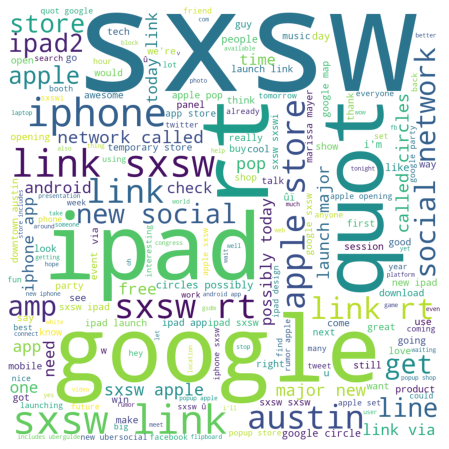

In [10]:
#importing the stopwords list to pass onto the WC generator
stopwords_list = stopwords.words('english')
stopwords_list.append('mention')

#droppping null values
df.dropna(inplace=True)

#instantiate
wc = WordCloud(background_color='white',
               stopwords=stopwords_list,
               height=1000,
               width=1000,
               )

#for the wordcloud, we have to join all the text data into a single string 
text = " ".join(df['tweet_text'])

#generate the WC
wc.generate(text)

#plot the WC
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(wc)
plt.show()

## FreqDist

Let's use nltk's FreqDist class to get some numbers to gives us more clarity

***Words like `a,as,the,for,that etc.` are used to make the sentence grammatically correct but give very little information about the contents of the text itself. Since they are most likely to occur a lot more than nouns and adjectives, they also distort our analysis and are hence best removed from the corpus for analysis.***

In [11]:
#defining a function to remove stopwords
def remove_stopwords(token_list):
    stopwords_removed = [token for token in token_list if token not in stopwords_list]
    return stopwords_removed

#applying the function to the text_token column
df['text_token'] = df['text_token'].apply(remove_stopwords)

In [12]:
#defining a function to plot the top_25 most occuring words

def plot_freq_dist(words):
    freq_dist = FreqDist(df[words].explode())
    # listing out the top 25 most occuring words and ther respective counts
    top_25 = list(zip(*freq_dist.most_common(25)))

    #creating a plot of the top_25 words
    fig,ax=plt.subplots(figsize=(10,10))
    ax.bar(top_25[0],top_25[1])
    ax.set_title('Top 25 most occurring words')
    ax.tick_params(axis='x', rotation=90)

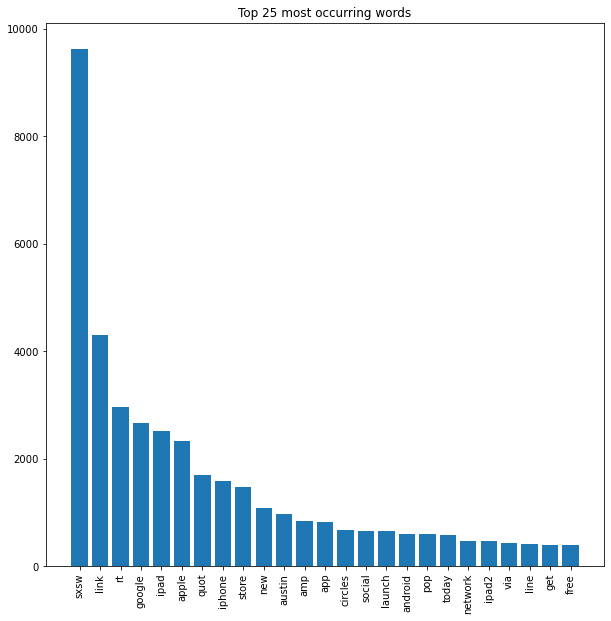

In [13]:
#plotting the freq_dist
plot_freq_dist('text_token')

***We can see from the above that the words `SXSW,Google,iPad` are some of the most tweeted words. A google search of `SXSW` reveals it to be arts and music festival held in Austin,TX. Hence, we can reasonably conclude that tweets collected for the analysis was from the city of Austin,TX and also coincided when the festival was running.***

# Analyzing emotions for each product_service

***This is to answer the first question : What are the emotional repsonses for each product_service category listed in the data? For eg: for the category 'Apple' how many positive,negative and neutral responses are there?***

***By comparing the responses for each category, we can gage customer sentiment***

In [14]:
#creating a pivot table to organize the data

df_pivot = df.pivot_table(index='product_service',aggfunc='count',columns='emotion')
df_pivot

text_token                   \
emotion            I can't tell Negative emotion   
product_service                                    
Android                     NaN             16.0   
Apple                       2.0             97.0   
Google                      2.0            115.0   
Not Applicable            147.0             51.0   
iPad                        4.0            125.0   
iPad or iPhone App          NaN             63.0   
iPhone                      1.0            103.0   

                                                                        \
emotion            No emotion toward brand or product Positive emotion   
product_service                                                          
Android                                           2.0            141.0   
Apple                                            22.0            575.0   
Google                                           24.0            582.0   
Not Applicable                                 5297.0            306.0   
iPad                                             24.0            793.0   
iPad or iPhone App                               10.0            397.0   
iPhone                                            9.0            184.0   

                     tweet_text                   \
emotion            I can't tell Negative emotion   
product_service                                    
Android                     NaN             16.0   
Apple                       2.0             97.0   
Google                      2.0            115.0   
Not Applicable            147.0             51.0   
iPad                        4.0            125.0   
iPad or iPhone App          NaN             63.0   
iPhone                      1.0            103.0   

                                                                        
emotion            No emotion toward brand or product Positive emotion  
product_service                                                         
Android                                           2.0            141.0  
Apple                                            22.0            575.0  
Google                                           24.0            582.0  
Not Applicable                                 5297.0            306.0  
iPad                                             24.0            793.0  
iPad or iPhone App                               10.0            397.0  
iPhone                                            9.0            184.0

In [15]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, Android to iPhone
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   (text_token, I can't tell)                        5 non-null      float64
 1   (text_token, Negative emotion)                    7 non-null      float64
 2   (text_token, No emotion toward brand or product)  7 non-null      float64
 3   (text_token, Positive emotion)                    7 non-null      float64
 4   (tweet_text, I can't tell)                        5 non-null      float64
 5   (tweet_text, Negative emotion)                    7 non-null      float64
 6   (tweet_text, No emotion toward brand or product)  7 non-null      float64
 7   (tweet_text, Positive emotion)                    7 non-null      float64
dtypes: float64(8)
memory usage: 504.0+ bytes


***Since the `text_column` is not relevant right now, let's remove it.***

In [16]:
#dropping the columns
df_pivot.drop(df_pivot.columns[[0,1,2,3]],axis=1,inplace=True)

***Since the columns are tuples, let's rename them for better understanding.***

In [17]:
#renaming the columns
df_pivot.columns = ["I can't tell",'Negative emotion','No emotion toward brand or product', 'Positive emotion']
df_pivot

,I can't tell,Negative emotion,No emotion toward brand or product,Positive emotion
product_service,,,,
Android,NaN,16.0,2.0,141.0
Apple,2.0,97.0,22.0,575.0
Google,2.0,115.0,24.0,582.0
Not Applicable,147.0,51.0,5297.0,306.0
iPad,4.0,125.0,24.0,793.0
iPad or iPhone App,NaN,63.0,10.0,397.0
iPhone,1.0,103.0,9.0,184.0


In [18]:
#dropping 'Not Applicable' since it is not relevant here
df_pivot.drop('Not Applicable',axis=0,inplace=True)

#rearranging the columns for better visualization
df_pivot=df_pivot[['Positive emotion','Negative emotion', 'No emotion toward brand or product', "I can't tell"]]

#sorting the values for better visuzalization
df_pivot.sort_values('Positive emotion',ascending=False,inplace=True)

df_pivot

,Positive emotion,Negative emotion,No emotion toward brand or product,I can't tell
product_service,,,,
iPad,793.0,125.0,24.0,4.0
Google,582.0,115.0,24.0,2.0
Apple,575.0,97.0,22.0,2.0
iPad or iPhone App,397.0,63.0,10.0,NaN
iPhone,184.0,103.0,9.0,1.0
Android,141.0,16.0,2.0,NaN


***Now that we've formatted the table to our liking, let's plot a bar chart see the different emotions for each product. This will give us an idea about how customers feel about each product***

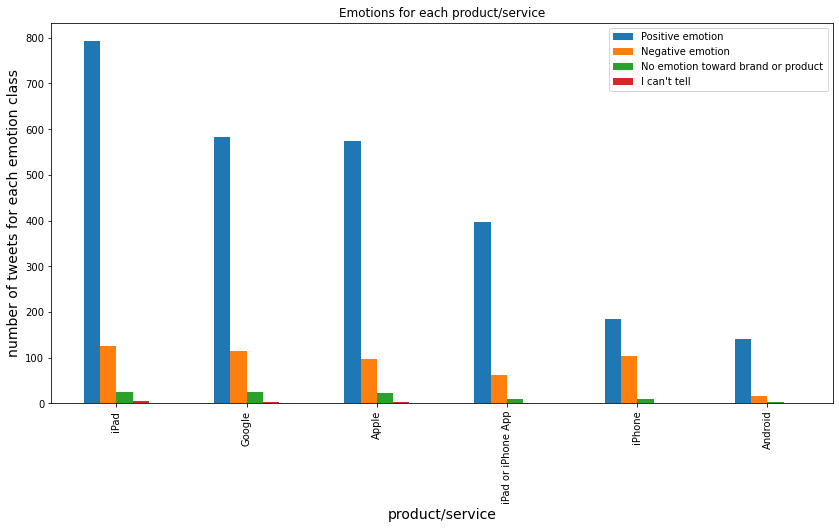

In [19]:
# bar chart listing emotion class for each product_service 

df_pivot.plot(kind='bar',figsize=(14,7));
plt.title('Emotions for each product/service');
plt.ylabel('number of tweets for each emotion class',fontsize=14);
plt.xlabel('product/service',fontsize=14);

***We have a clear winner in iPad! i.e. the iPad is the most popular product among customers and Android the least. We can also that the number of negative tweets seem to be somewhat level across all products except for Android.***

# What do customers like about a product_service?

***Here, we are looking to answer the second question.We can do this by breaking down each product_service and the different emotions to see if there are any key words that stand out. For eg: we can list out tweets by positive and negative emotions for iPad and analyze separately to gage sentiment.***

In [20]:
#updating stopwords list to include SXSW since it appears nearly 10,000 times
stopwords_list.append('SXSW')

***Let's define some functions to make things easier.***

***Function to get only positive tweets***

In [21]:
def get_positive(df,category,emotion):
    positive_df = df.loc[(df['product_service']==category) & (df['emotion']=='Positive emotion')]
    return positive_df        

***Function to get only negative tweets***

In [22]:
def get_negative(df,category,emotion):
    negative_df=df.loc[(df['product_service']==category) & (df['emotion']=='Negative emotion')]
    return negative_df
        

In [23]:
#define a function to generate worclouds for a category

# def wordcloud_gen(df,category):
#     pos=get_positive(df,category,'Positive emotion')
#     neg=get_negative(df,category,'Negative emotion')
#     product = category
#     wordcloud=[]
#     for i in [pos, neg]:
#         #instantiate
#         wc = WordCloud(background_color='white',
#                            stopwords=stopwords_list,
#                            height=1000,
#                            width=1000,
#                            )
#         #for the wordcloud, we have to join all the text data into a single string 
#         text = " ".join(i['tweet_text'])
#         #generate the WC
#         wordcloud.append(wc.generate(text))
#     #plot the WC
#     fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
#     font = {'fontsize':20}
#     ax1.imshow(wordcloud[0])
#     ax1.axis('off')
#     ax1.set_title(f'Positive emotions:{product}',fontdict=font);
#     ax2.imshow(wordcloud[1])
#     ax2.axis('off')
#     ax2.set_title(f'Negative emotions:{product}',fontdict=font);


***Function to generate Wordclouds for positive and negative tweets***

In [24]:
def wordcloud_gen(df,category):
    pos=get_positive(df,category,'Positive emotion')
    neg=get_negative(df,category,'Negative emotion')
    product = category # for use in the heading of the wordcloud

    #instantiate wordclouds
    wc1 = WordCloud(background_color='white',   #positive wc
               stopwords=stopwords_list,
               height=1000,
               width=1000,
               )
    wc2 = WordCloud(background_color='black',   #negative wc
               stopwords=stopwords_list,
               height=1000,
               width=1000,
               )

#for the wordcloud, we have to join all the text data into a single string 
    text1 = " ".join(pos['tweet_text']) #positive
    text2 = " ".join(neg['tweet_text']) #negative

#generate the WC
    wc1.generate(text1) #positive
    wc2.generate(text2) #negative

#plot the WC
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
    font = {'fontsize':20}
    ax1.imshow(wc1) #positve
    ax1.axis('off')
    ax1.set_title(f'Positive emotions:{product}',fontdict=font);
    ax2.imshow(wc2) #negative
    ax2.axis('off')
    ax2.set_title(f'Negative emotions:{product}',fontdict=font);

## Ipad

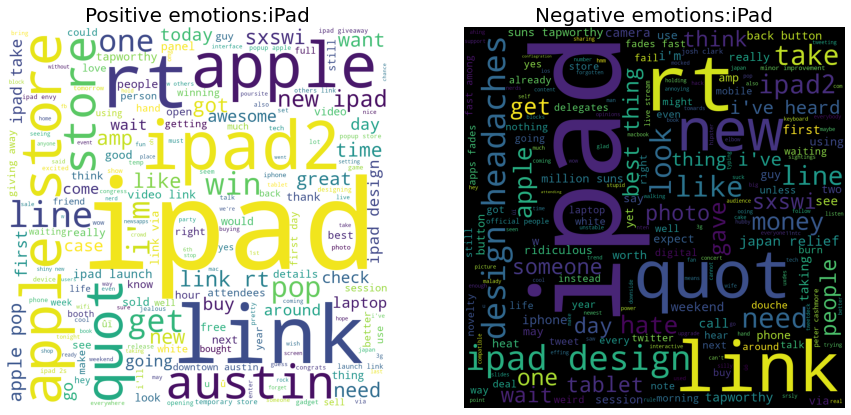

In [25]:
wordcloud_gen(df,'iPad')

***From the negative emotions, we can see `design headaches, iPad design,money,back button` are some of the words that feature prominently thus illustrating displeasure of the users regarding some of the features of the `iPad`. `iPad2` is also mentioned quite a lot.***

## Apple

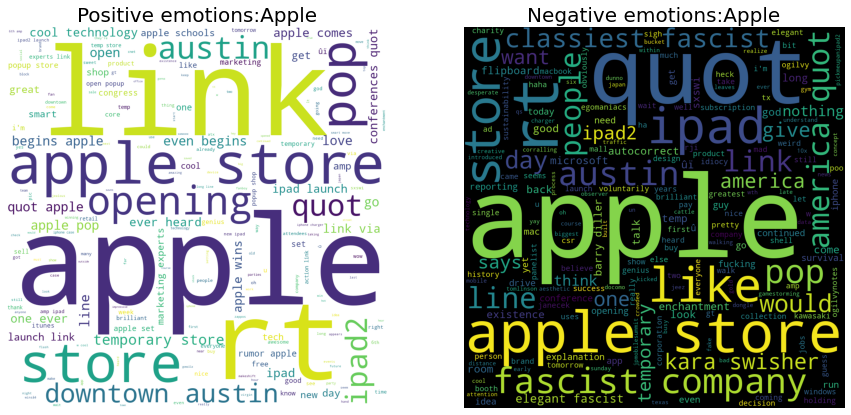

In [26]:
wordcloud_gen(df,'Apple')

***Sentiment against Apple seems to be quite severe given the high number of tweets featuring the word `fascist`!***

## iPhone

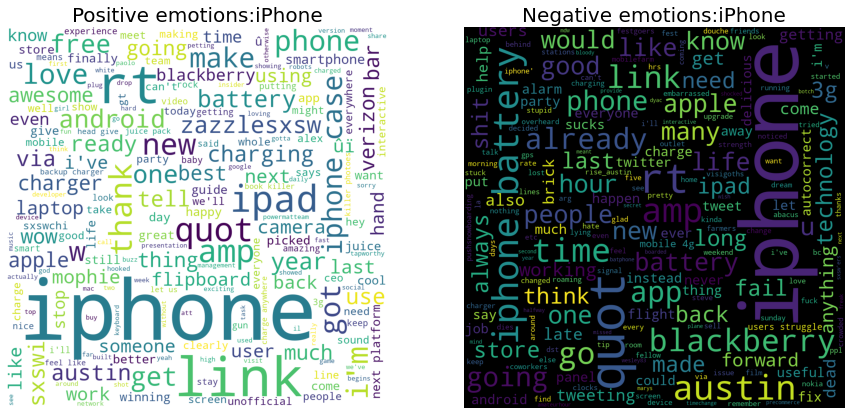

In [27]:
wordcloud_gen(df,'iPhone')

***From positive emotions, `verizon` stands out suggesting their superiority from the other carriers. `iphone battery,battery` from the negative emotions illustrate unequivocally where the problem lies with the iPhone.***

## Ipad and iPhone apps

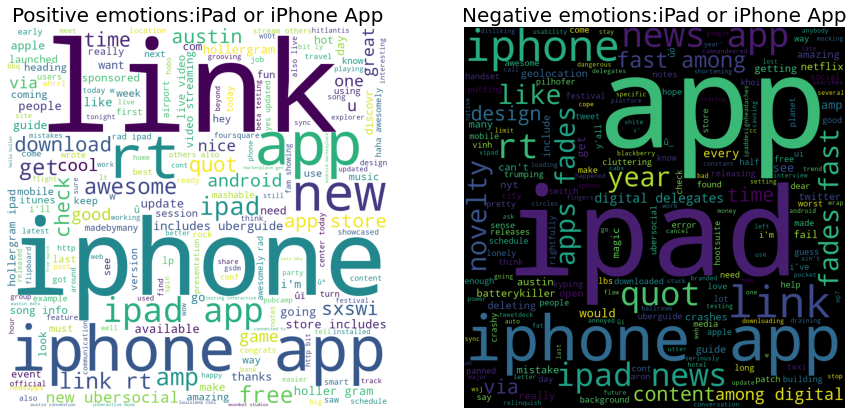

In [28]:
wordcloud_gen(df,'iPad or iPhone App')

## Google

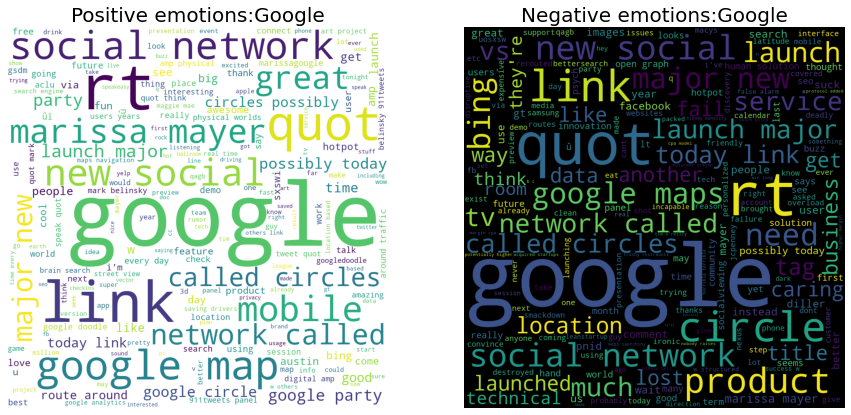

In [29]:
wordcloud_gen(df,'Google')

***`google maps` seems to be equally represented in both positive and negative tweets. Some people like it and some don't.
Same thing with `social network`. How that ties in with `google` needs some more exploration.***

## Android

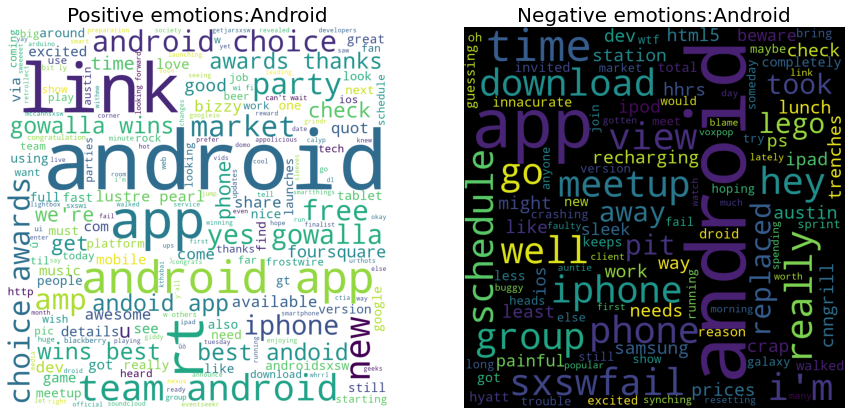

In [30]:
wordcloud_gen(df,'Android')

***The words `awards,wins best` from the positve tweets maybe point towards someone from the festival winning or an app on the Android platform winning some award! `Samsung` pops up in negative tweets suggesting issues with apps running on Samsung phones.***

# Model to predict product_service from tweets

***Let's make this a binary classification problem i.e. we will group all Apple and Google products together for ease of modelling.***

In [31]:
#let's group product/services that resemble each other for both brands. This will make for easier analysis

df['product_service'].replace('Android','Google',inplace=True)
df['product_service'].replace(['iPhone','iPad','iPad or iPhone App'],'Apple',inplace=True)

#checking 
df['product_service'].value_counts()

Not Applicable    5801
Apple             2409
Google             882
Name: product_service, dtype: int64

In [32]:
# creating target values for product_service
new_map = {'Not Applicable':0,
          'Apple':1,
          'Google':2}

df['target'] = df['product_service'].map(new_map)
df.head()

,tweet_text,product_service,emotion,text_token,target
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus...",1
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",1
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph...",1
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",2


## Building baseline models using CountVectorizer

In [33]:
#setting up X,y train and test sets
X= df['text_token']
y = df['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)

#use the default pattern in sklearn for tokenizing
# basic_token_pattern = r"(?u)\b\w\w+\b"

In [34]:
def dummy(doc):
    return doc

In [35]:
# building a pipeline of LogisticRegression, Naive-Bayes, SVM and RandomForest models

# instantiate all the models

pipe_lr = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

pipe_nb = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',MultinomialNB())
                    ])

pipe_rf = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',RandomForestClassifier(random_state=123))
                    ])

pipe_svm = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',svm.SVC(random_state=123))
                    ])

#setting up names for the classification report
names_dict = dict(df['product_service'].value_counts())
names = [name for name in names_dict]

#build a list of tuples to build a df
models=['LogReg', 'MultiNB', 'RForest', 'SVM']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr,pipe_nb,pipe_rf,pipe_svm]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#building a df of the f1_scores
scores = list(zip(models,f1))
scores_df = pd.DataFrame(data=scores,columns=['model','f1_score_cv'])

## Building baseline models using Tf-idf Vectorizer

In [36]:
# repeating the same processes as above
pipe_lr = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

pipe_nb = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',MultinomialNB())
                    ])

pipe_rf = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',RandomForestClassifier(random_state=123))
                    ])

pipe_svm = Pipeline([('vectrorizer',TfidfVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',svm.SVC(random_state=123))
                    ])

#setting up names for the classification report
names_dict = dict(df['product_service'].value_counts())
names = [name for name in names_dict]

#build a list of tuples to build a df
models=['LogReg', 'MultiNB', 'RForest', 'SVM']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr,pipe_nb,pipe_rf,pipe_svm]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#adding the tf f1-scores to the scores_df
scores_df['f1_score_tf'] = f1

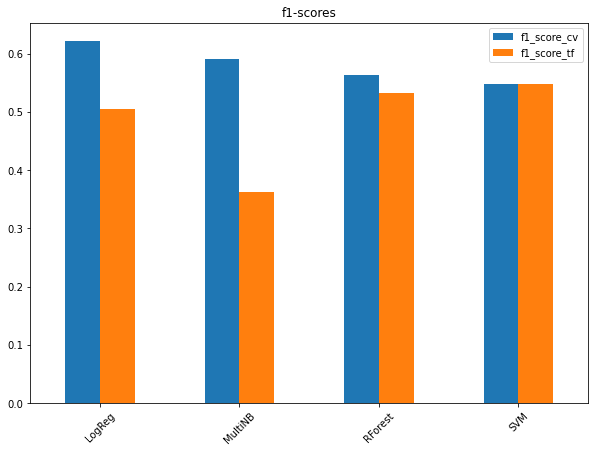

In [37]:
#visualizing the f1-scores of all the models for the two vectorizers

fig,ax = plt.subplots(figsize=(10,7))
scores_df.plot(kind='bar',ax=ax);
ax.set_xticklabels(models,rotation=45);
ax.set_title('f1-scores');


Since the LogisticRegression model with the CountVectorizer has the highest f1-score among all models, let's use that for optimizations

# Tuning LogisticRegression with Countvectorizer

Let's get some more information of model performance

                precision    recall  f1-score   support

Not Applicable       0.75      0.85      0.80      1449
         Apple       0.66      0.54      0.59       593
        Google       0.62      0.39      0.48       231

      accuracy                           0.72      2273
     macro avg       0.68      0.59      0.62      2273
  weighted avg       0.71      0.72      0.71      2273



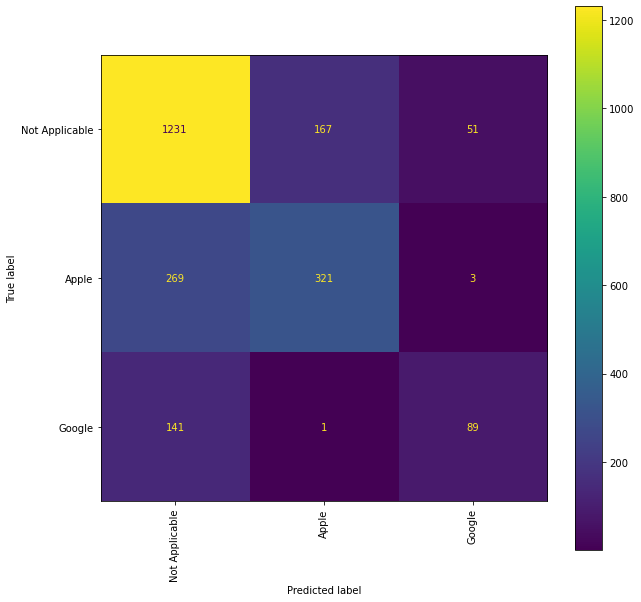

In [38]:
lr_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

lr_pipe.fit(X_train,y_train)
predictions=lr_pipe.predict(X_test)
print(classification_report(y_test,predictions,target_names=names))
fig,ax=plt.subplots(figsize=(10,10))
plot_confusion_matrix(lr_pipe,X_test,y_test,display_labels=names,ax=ax,xticks_rotation='vertical');

## min_df and max_df values

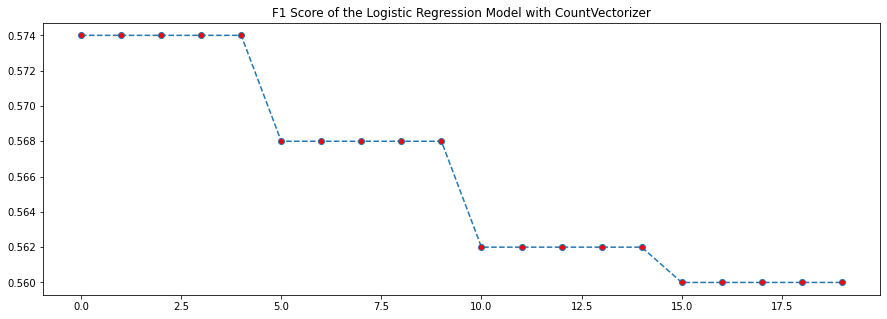

In [39]:
# setting a range for min_df and max_df
min_df_value = np.arange(1,5) # words than appear less than the min_df value in all docs will be eliminated
max_df_value = np.arange(1500,1505) # words than appear more than the max_df value in all docs will be eliminated

#initiating lists to use for plotting
f_score = []
min_value=[]
max_value=[]

#setting up the loop for min_df and max_df values
for i in min_df_value:
    for j in max_df_value:
        min_value.append(i)
        max_value.append(j)
        #instantiate pipeline
        new_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,min_df=i,max_df=j,preprocessor=dummy,tokenizer=dummy)),
                                   ('model',LogisticRegression(random_state=123,solver='liblinear'))
                                   ])
        new_pipe.fit(X_train,y_train)
        preds = new_pipe.predict(X_test)

        #getting f1 score
        score = round(f1_score(y_test,preds,average='macro'),3)
        f_score.append(score)
#         print(f'min_df = {i}, max_df = {j}, f1_score={score}')

#visualizing the accuracy score for the different combinations
d = list(zip(min_value,max_value))
fig,ax=plt.subplots(figsize=(15,5))
ax.plot(f_score,marker='o',markerfacecolor='r',ls='--');
# ax.set_xticklabels(d);
ax.set_title('F1 Score of the Logistic Regression Model with CountVectorizer');

## n-gram

Since the changing the min_df and max_df values, made the model performance worse, let's try changing the n-gram parameter

In [40]:
lr_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy,
                                                  ngram_range=(1,2),min_df=1,max_df=2000)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

lr_pipe.fit(X_train,y_train)
predictions=lr_pipe.predict(X_test)
print(classification_report(y_test,predictions,target_names=names))
# fig,ax=plt.subplots(figsize=(10,10))
# plot_confusion_matrix(lr_pipe,X_test,y_test,display_labels=names,ax=ax,xticks_rotation='vertical');

                precision    recall  f1-score   support

Not Applicable       0.75      0.86      0.80      1449
         Apple       0.67      0.54      0.60       593
        Google       0.63      0.35      0.45       231

      accuracy                           0.73      2273
     macro avg       0.68      0.59      0.62      2273
  weighted avg       0.72      0.73      0.71      2273



We can see that there is no disceernible change in model performance

## Stemming using PorterStemmer

In [41]:
#initializing the stemmer
ps=PorterStemmer()

#creating a function to tokenize and stem the tokens
def stem_and_tokenize(document):
    tokens = tokenizer.tokenize(document)
    return [ps.stem(token) for token in tokens]

In [42]:
df['stemmed_tokens'] = df['tweet_text'].apply(stem_and_tokenize)
df.head()

,tweet_text,product_service,emotion,text_token,target,stemmed_tokens
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus...",1,"[wesley83, have, 3g, iphon, after, hr, tweet, ..."
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1,"[jessede, know, about, fludapp, awesom, ipad, ..."
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",1,"[swonderlin, can, not, wait, for, ipad, also, ..."
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph...",1,"[sxsw, hope, thi, year, festiv, isn, as, crash..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",2,"[sxtxstate, great, stuff, on, fri, sxsw, maris..."


In [43]:
#running logistic regression on the stemmed tokens
#re-defining X and y
X = df['stemmed_tokens']
y = df['target']

X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y,random_state=123)

In [44]:
lr_pipe = Pipeline([('vectrorizer',CountVectorizer(stop_words=stopwords_list,preprocessor=dummy,tokenizer=dummy,
                                                  ngram_range=(1,2),min_df=1,max_df=2000)),
                    ('model',LogisticRegression(random_state=123,solver='liblinear'))
                   ])

lr_pipe.fit(X_train2,y_train2)
predictions=lr_pipe.predict(X_test2)
print(classification_report(y_test2,predictions,target_names=names))

                precision    recall  f1-score   support

Not Applicable       0.75      0.85      0.80      1449
         Apple       0.66      0.55      0.60       593
        Google       0.61      0.37      0.46       231

      accuracy                           0.72      2273
     macro avg       0.67      0.59      0.62      2273
  weighted avg       0.71      0.72      0.71      2273



# Word2Vec

In [45]:
#instantiate the vect
model = Word2Vec(df['text_token'], vector_size=100, window=2, min_count=5,sg=1)

#train the model
model.train(df['text_token'],epochs=10,total_examples=model.corpus_count)

(636477, 1049380)

## Experimentation

In [46]:
#the calculated vectors are stored in the Word2VecKeyedVectors instance stored in the wv attribute
#assign it to a different variable to save yourself from lots'of keystrokes
wv=model.wv

In [47]:
#checking the vector for the word 'battery'. this will tell us the probablity that the model has calulated for the context 
# that the word 'battery' will most likely used in 
wv.most_similar('battery')

[('brightness', 0.8371030688285828),
 ('double', 0.8263407945632935),
 ('charge', 0.8211798667907715),
 ('charging', 0.80194491147995),
 ('backup', 0.80105060338974),
 ('size', 0.7786024212837219),
 ('half', 0.7743921875953674),
 ('caring', 0.7740436792373657),
 ('blue', 0.7728219032287598),
 ('life', 0.7692567110061646)]

In [48]:
#the vector assocaited with the word 'battery'
wv['battery']

array([-0.32474756, -0.03428779,  0.35822064, -0.34978998,  0.27827895,
       -0.15421337,  0.04875082,  0.06563469,  0.04342594, -0.20535667,
       -0.289028  , -0.12198574, -0.00300358, -0.38445237,  0.2867324 ,
       -0.6592583 , -0.17115502, -0.43228212, -0.09981392, -0.3619752 ,
        0.11186091,  0.09412744,  0.29454347,  0.17114405, -0.1015245 ,
        0.05555297, -0.07076868,  0.00129686, -0.13871329,  0.16533658,
       -0.36068016,  0.40994877, -0.3526225 , -0.08009035,  0.13661134,
        0.04567593, -0.26123238, -0.4815107 , -0.25093323, -0.51428074,
        0.0042194 , -0.36783138, -0.0593736 , -0.03534457,  0.3854403 ,
       -0.28297424, -0.08459216,  0.38762447, -0.29286915,  0.4179364 ,
        0.12439005, -0.13264768,  0.22583206,  0.13658951, -0.5228464 ,
        0.00718135, -0.25889504,  0.04325115, -0.11902718,  0.10942847,
        0.08537485, -0.05128553,  0.10210279, -0.22335635, -0.41200614,
       -0.12031247, -0.08364382,  0.24623723, -0.42576498,  0.18

In [49]:
#getting the list of words from the model
words = list(model.wv.index_to_key)
words[0:10]

['sxsw',
 'link',
 'rt',
 'google',
 'ipad',
 'apple',
 'quot',
 'iphone',
 'store',
 'new']

In [50]:
#getting the vectors assocated with each of those words
vector_list = [model.wv[word] for word in words]
vector_list[0]

array([ 0.26089057,  0.2602105 ,  0.16752297,  0.1171306 ,  0.26390123,
       -0.416287  ,  0.2100801 ,  0.5279305 , -0.9018738 ,  0.00615661,
        0.07641938,  0.01419971,  0.17694283,  0.42696172, -0.4480845 ,
        0.21947248,  0.2774312 ,  0.29545224, -0.44350204, -0.29279113,
        0.36373827,  0.3701474 ,  0.28274807, -0.47688925, -0.10374458,
        0.07827894, -0.29802835,  0.00909044,  0.19890507, -0.06078473,
        0.30626443, -0.22201239,  0.26395714,  0.07045938, -0.08825886,
        0.09908123,  0.17631598,  0.19980578,  0.07474601, -0.5076188 ,
       -0.14537324,  0.10452691,  0.33494037, -0.36925173,  0.0656429 ,
        0.10214597, -0.3164713 ,  0.592408  , -0.04743639,  0.4862639 ,
        0.18573236,  0.22712477, -0.41640544, -0.11712916,  0.06912977,
       -0.106388  ,  0.06132432, -0.2508136 , -0.19077876, -0.28031322,
       -0.12074295,  0.0419969 ,  0.15599996, -0.23506795, -0.35345158,
        0.10648587,  0.19074741,  0.05376202, -0.12322905, -0.23

In [51]:
#creating a df
word_vect_zip = dict(zip(words,vector_list))
word_vect_df = pd.DataFrame(word_vect_zip)
word_vect_df.head()

,sxsw,link,rt,google,ipad,apple,quot,iphone,store,new,...,record,presentations,diff,teo,copyright,akqa,produced,mtg,wine,optimistic
0,0.260891,-0.145346,-0.094768,0.230555,-0.567864,0.003399,0.079212,0.392033,-0.214311,-0.322922,...,-0.091160,-0.009589,-0.043549,-0.147654,-0.064593,-0.178140,-0.038231,-0.113397,-0.036295,-0.075457
1,0.260211,0.706074,0.161572,0.873657,-0.165287,0.268671,0.184877,-0.135045,0.391326,0.202442,...,0.110126,0.029150,0.102663,0.138668,0.038762,0.103327,0.133777,0.048831,0.083363,0.085150
2,0.167523,0.182966,-0.303838,-0.130332,0.135369,-0.165673,-0.032337,0.613915,0.288157,-0.011439,...,0.020297,0.082987,-0.030389,0.052979,-0.053227,-0.037120,-0.037535,0.032134,0.065801,0.038245
3,0.117131,0.176461,0.115727,0.145003,0.051409,-0.439086,-0.121254,0.225819,0.204024,0.425633,...,0.053050,-0.061861,0.066441,0.142121,0.043812,0.160249,-0.100753,0.114172,-0.021987,-0.071543
4,0.263901,0.099259,0.455149,0.351941,0.236894,-0.423103,0.213807,0.005244,0.375577,0.203794,...,0.040855,0.008575,0.070832,0.118448,-0.034328,0.082197,0.032088,-0.062828,0.012730,0.074573


In [52]:
# now we need to get a vector reprsentation for each document to be able to apply a ML model
# for this, you will take the mean of the vector representation of each document

In [53]:
#to get the vector representation of each document, you will define a fuction that will create a 
#vector for each word in the document that is in the model's vocab,beacuse obviously you cannot have
#vectors for words that are not there. Then you will take the average of the vectors and the resultant 
#vector will the vector for that document

def doc_vector(token):
    vector_size=model.wv.vector_size #getting the size of the vectors created 
    resultant_vector = np.zeros(vector_size) # initializing a vector of zeros of the same size
    ctr=1 #counter
    for w in token:
        if w in words:
            ctr += 1
            resultant_vector += wv[w]
    resultant_vector = resultant_vector/ctr
    return resultant_vector

In [54]:
#applying the function to the stemmed_tokens colums
df['vectors'] = df['stemmed_tokens'].apply(doc_vector)
df.head()

,tweet_text,product_service,emotion,text_token,target,stemmed_tokens,vectors
0,.@wesley83 i have a 3g iphone. after 3 hrs twe...,Apple,Negative emotion,"[wesley83, 3g, iphone, hrs, tweeting, rise_aus...",1,"[wesley83, have, 3g, iphon, after, hr, tweet, ...","[-0.011246822175702878, 0.0660585133092744, 0...."
1,@jessedee know about @fludapp ? awesome ipad/i...,Apple,Positive emotion,"[jessedee, know, fludapp, awesome, ipad, iphon...",1,"[jessede, know, about, fludapp, awesom, ipad, ...","[-0.0885423619300127, -0.1176531694829464, 0.3..."
2,@swonderlin can not wait for #ipad 2 also. the...,Apple,Positive emotion,"[swonderlin, wait, ipad, also, sale, sxsw]",1,"[swonderlin, can, not, wait, for, ipad, also, ...","[-0.13659624755382538, 0.04158589926858743, 0...."
3,@sxsw i hope this year's festival isn't as cra...,Apple,Negative emotion,"[sxsw, hope, year, festival, crashy, year, iph...",1,"[sxsw, hope, thi, year, festiv, isn, as, crash...","[0.046244386051382334, 0.0792306097490447, 0.2..."
4,@sxtxstate great stuff on fri #sxsw: marissa m...,Google,Positive emotion,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",2,"[sxtxstate, great, stuff, on, fri, sxsw, maris...","[-0.06972267079566206, 0.07242554452802454, -0..."


## Modelling

***Now that we have a vecotrized represtation of each document, we can apply different ML models***

In [55]:
#redefining X&y
X= df['vectors'].to_list()
y = df['target'].to_list()

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=123)

In [56]:
# repeating the same processes as above
pipe_lr_wv = Pipeline([('model',LogisticRegression(random_state=123,solver='liblinear'))])

# pipe_nb_wv = Pipeline([('model',MultinomialNB())])
#cannot use NB on negative values. Values will have to be normalized instead

pipe_rf_wv = Pipeline([('model',RandomForestClassifier(random_state=123))])

pipe_svm_wv = Pipeline([('model',svm.SVC(random_state=123))])

#build a list of tuples to build a df
models=['LogReg_wv', 'RForest_wv', 'SVM_wv']
f1 = []

#fitting the models on the train sets
pipelines = [pipe_lr_wv,pipe_rf_wv,pipe_svm_wv]

for pipe in pipelines:
    pipe.fit(X_train,y_train)
    predictions = pipe.predict((X_test))
#     print(pipe)
#     print(classification_report(y_test,predictions,target_names=names))
    f1.append(f1_score(y_test,predictions,average='macro'))
    
#building a df of the f1_scores
scores_wv = list(zip(models,f1))
scores_df_wv = pd.DataFrame(data=scores_wv,columns=['model','f1_score_wv'])

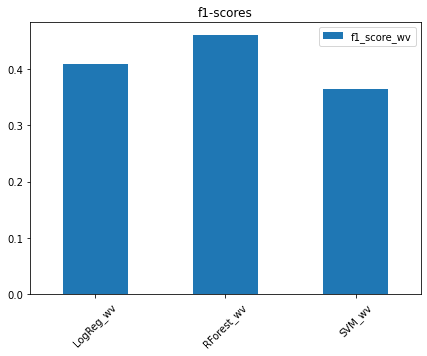

In [57]:
fig,ax = plt.subplots(figsize=(7,5))
scores_df_wv.plot(kind='bar',ax=ax);
ax.set_xticklabels(models,rotation=45);
ax.set_title('f1-scores');

# Next Steps